In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


100%|██████████| 2.29G/2.29G [00:35<00:00, 69.5MB/s]

Extracting files...


Data source import complete.


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,classification_report ,roc_curve, auc ,precision_recall_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import cv2
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121, ResNet50V2, EfficientNetB2, InceptionV3, VGG16
from tensorflow.keras.activations import swish
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_path  = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_path   = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

labels =['NORMAL' ,'PNEUMONIA']

In [ ]:
import os

# List all files in the Kaggle dataset directory
print(os.listdir("/kaggle/input"))


[]


In [ ]:
train_path = "/kaggle/input/<your-dataset-folder>/chest_xray/train"


In [ ]:
import os

if os.path.exists(train_path):
    print("✅ Path exists:", train_path)
else:
    print("❌ Path does not exist:", train_path)


- **Show some images from each class**

In [ ]:
i =0
counts = {}

for label in labels :
    path =os.path.join(train_path ,label)
    counts[label] = len(os.listdir(path))
    x =0
    print(f'{label} : Class number {i} , that contain {len(os.listdir(path))} image')
    for img in os.listdir(path):
        x +=1
        img =cv2.imread(os.path.join(path ,img) ,cv2.IMREAD_GRAYSCALE)
        plt.imshow(img ,cmap ='gray')
        plt.show()
        if x ==5 :
            print('=='*40)
            break
    i +=1

In [ ]:
df = pd.DataFrame(list(counts.items()), columns=['Label', 'Count'])
df.set_index('Label', inplace=True)


df.plot(kind='bar', legend=False)

plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

In [ ]:
img.shape

In [ ]:
img_size =224

resized_img =cv2.resize(img ,(img_size ,img_size) ,1)
plt.imshow(resized_img ,cmap ='gray')
plt.show()

In [ ]:
img.max(), img.min()

## Training Data

In [ ]:
train_generator=ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
).flow_from_directory(train_path,
                      batch_size=32,
                      target_size=(img_size, img_size),
                      subset="training",
                      color_mode='rgb',
                      class_mode='binary',
                      shuffle=True)

In [ ]:
labels=list(train_generator.class_indices.keys())
labels

In [ ]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        #plt.title(labels[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        plt.title(labels[int(y_batch[i])])   # when y is binary or sparse
        plt.axis('off')
        plt.grid(None)
    # show the plot
    plt.show()
    break

## Validation & Testing

- we don't need to make augmentation on test or validation data so, i will normalized data only.

In [ ]:
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
).flow_from_directory(test_path,
                      batch_size=32,
                      target_size=(img_size, img_size),
                      color_mode='rgb',
                      class_mode='binary',
                      shuffle=False)


val_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
).flow_from_directory(val_path,
                      batch_size=32,
                      target_size=(img_size, img_size),
                      color_mode='rgb',
                      class_mode='binary')

# Model Training

# Simple CNN

In [ ]:
size = (img_size, img_size, 3)
num_classes = len(labels)


CNN_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=size, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compile with lower learning rate
CNN_model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


print(CNN_model.summary())

In [ ]:
history_CNN = CNN_model.fit(train_generator,
                    epochs = 5,
                    batch_size=32,
                    validation_data = test_generator,
                    callbacks = early_stopping
                    )

In [ ]:
CNN_model.save('simpleCNN_pneumonia.h5')

In [ ]:
# Evaluate the model
test_loss, test_acc = CNN_model.evaluate(test_generator)
print('Test accuracy:', test_acc)
print('Test accuracy:', test_loss)

In [ ]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_CNN.history['accuracy'], label='Train Accuracy')
plt.plot(history_CNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_CNN.history['loss'], label='Train Loss')
plt.plot(history_CNN.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

- **Classification Report**

In [ ]:
from sklearn.metrics import classification_report

# Predict on test data
y_pred = CNN_model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values

# Get true labels
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred))

- **Confusion Matrix**

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on test data
y_pred = CNN_model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values

# Get true labels
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


<ipython-input-19-15e64402b450>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_names[int(predicted_labels[i])]


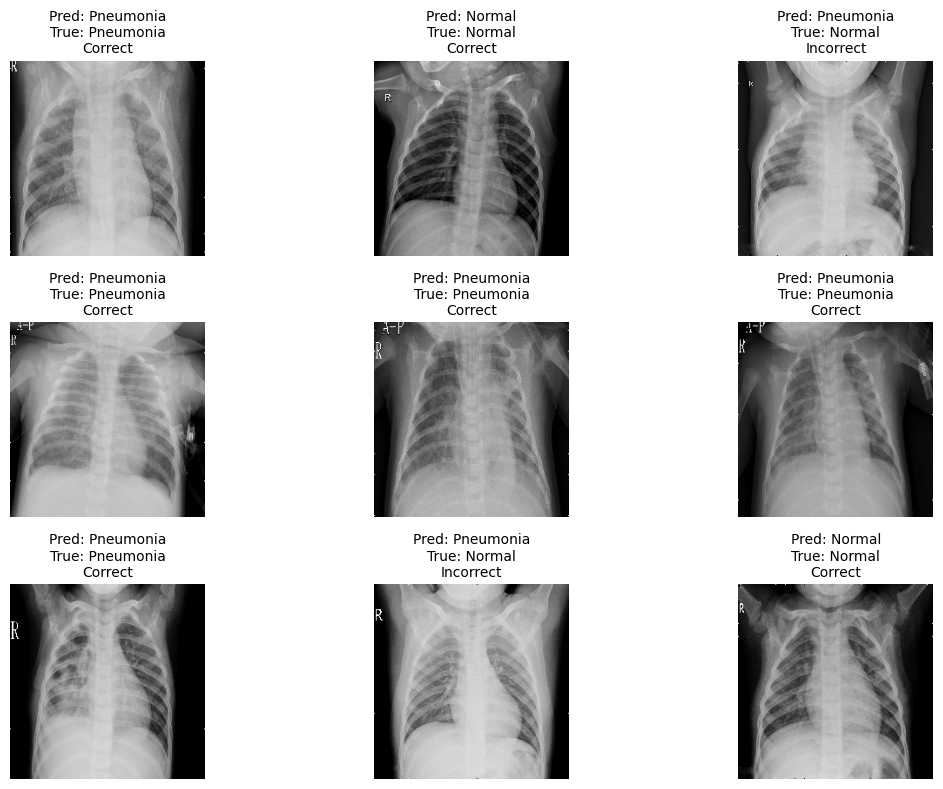

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels from validation generator
val_images, val_labels = next(val_generator)  # Take one batch

# Predict labels
predictions = CNN_model.predict(val_images)
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Get class names
class_names = ['Normal', 'Pneumonia']

# Plot images with prediction results
plt.figure(figsize=(12, 8))
for i in range(9):  # Show 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(val_images[i], cmap='gray')  # Display image

    true_label = class_names[int(val_labels[i])]  # Fixed indexing
    predicted_label = class_names[int(predicted_labels[i])]

    # Check if prediction is correct
    correctness = "Correct" if true_label == predicted_label else "Incorrect"

    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}\n{correctness}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Densenet

In [ ]:
size = (img_size, img_size, 3)
num_classes = len(labels)



# Load DenseNet121 with pre-trained ImageNet weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=size)

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

print(model.summary())

In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
model.save('densenet_pneumonia.h5')

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)
print('Test accuracy:', test_loss)

In [ ]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Predict on test data
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values

# Get true labels
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred))

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on test data
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values

# Get true labels
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Deployment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels from validation generator
val_images, val_labels = next(val_generator)  # Take one batch

# Predict labels
predictions = model.predict(val_images)
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Get class names
class_names = ['Normal', 'Pneumonia']

# Plot images with prediction results
plt.figure(figsize=(12, 8))
for i in range(9):  # Show 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(val_images[i], cmap='gray')  # Display image

    true_label = class_names[int(val_labels[i])]  # Fixed indexing
    predicted_label = class_names[int(predicted_labels[i])]

    # Check if prediction is correct
    correctness = "Correct" if true_label == predicted_label else "Incorrect"

    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}\n{correctness}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load trained model
model = tf.keras.models.load_model("densenet_pneumonia.h5")  # Change to your model path

# Class labels (Modify if needed)
class_names = ['Normal', 'Pneumonia']

# Function to make predictions
def predict_image(img):
    img = img.resize((img_size, img_size))  # Resize image to model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    prediction = model.predict(img_array)[0][0]  # Get prediction score

    predicted_label = "Pneumonia" if prediction > 0.5 else "Normal"

    return f"Model Prediction: {predicted_label}"

# Create Gradio app
interface = gr.Interface(fn=predict_image, inputs="image", outputs="text")
interface.launch()